In [13]:
import pandas as pd

# Load the dataset
df = pd.read_csv("job_applicant_dataset.csv")

# Preview the first few rows
print(df.head())

  Job Applicant Name  Age  Gender             Race   Ethnicity  \
0       Daisuke Mori   29    Male  Mongoloid/Asian  Vietnamese   
1     Taichi Shimizu   31    Male  Mongoloid/Asian    Filipino   
2       Sarah Martin   46  Female  White/Caucasian       Dutch   
3       Keith Hughes   43    Male    Negroid/Black   Caribbean   
4        James Davis   49    Male  White/Caucasian     English   

                                              Resume             Job Roles  \
0  Proficient in Injury Prevention, Motivation, N...         Fitness Coach   
1  Proficient in Healthcare, Pharmacology, Medica...             Physician   
2  Proficient in Forecasting, Financial Modelling...     Financial Analyst   
3  Proficient in Budgeting, Supply Chain Optimiza...  Supply Chain Manager   
4  Proficient in Logistics, Negotiation, Procurem...  Supply Chain Manager   

                                     Job Description  Best Match  
0   A Fitness Coach is responsible for helping cl...           0  


In [14]:
# import
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
from scipy.sparse import hstack
import matplotlib.pyplot as plt


# Functions 
def load_and_prepare_data(filepath):
    df = pd.read_csv(filepath).reset_index(drop=True)
    df['row_id'] = df.index
    df['Text'] = df['Resume'].fillna('') + ' ' + df['Job Description'].fillna('')
    return df

def encode_categorical_columns(df, categorical_cols):
    encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le
    return df, encoders

def split_dataset(df, test_size=0.2, seed=42):
    train_ids, test_ids = train_test_split(df['row_id'].values, test_size=test_size, random_state=seed)
    return df.loc[train_ids].copy(), df.loc[test_ids].copy()

def prepare_features(df_train, df_test, structured_cols, text_col='Text', max_features=300):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_features)
    X_text_train = vectorizer.fit_transform(df_train[text_col])
    X_text_test = vectorizer.transform(df_test[text_col])

    X_structured_train = df_train[structured_cols].values
    X_structured_test = df_test[structured_cols].values

    X_train = hstack([X_text_train, X_structured_train])
    X_test = hstack([X_text_test, X_structured_test])

    y_train = df_train['Best Match'].values
    y_test = df_test['Best Match'].values

    return X_train, X_test, y_train, y_test, vectorizer

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("📊 Model Performance (Random Forest):")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, zero_division=0))
    print("Recall:", recall_score(y_test, y_pred, zero_division=0))
    print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return model, y_pred

# === 3. Execution ===

df = load_and_prepare_data("job_applicant_dataset.csv")
df, label_encoders = encode_categorical_columns(df, ['Gender', 'Race', 'Ethnicity'])
df_train, df_test = split_dataset(df)

structured_features = ['Age', 'Gender', 'Race', 'Ethnicity']
X_train, X_test, y_train, y_test, tfidf_vectorizer = prepare_features(df_train, df_test, structured_features)

rf_model, y_pred_rf = train_and_evaluate_model(X_train, y_train, X_test, y_test)


📊 Model Performance (Random Forest):
Accuracy: 0.8555
Precision: 0.860587002096436
Recall: 0.8403275332650972
F1 Score: 0.8503366131538063

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1023
           1       0.86      0.84      0.85       977

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

Confusion Matrix:
 [[890 133]
 [156 821]]



✅ Selection Rate by Gender:
Gender
0    0.323013
1    0.621726
Name: y_pred, dtype: float64

📉 Disparate Impact Ratio (DIR): 0.520

⚖️ Equal Opportunity Difference: 0.136


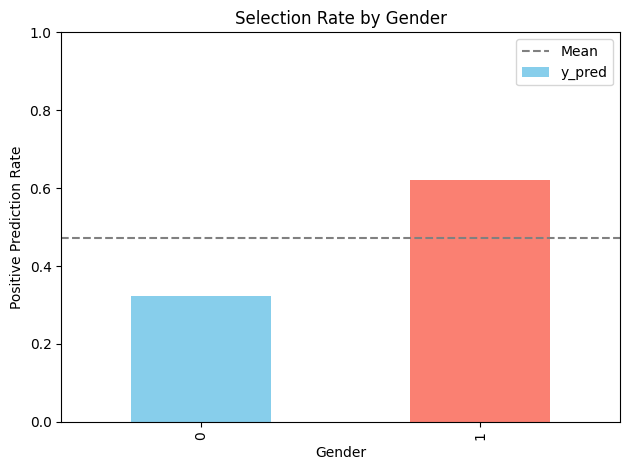

In [15]:
from sklearn.metrics import recall_score

def evaluate_fairness_by_group(df_test, y_pred, y_true, group_col='Gender'):
    df_test = df_test.copy()
    df_test['y_true'] = y_true
    df_test['y_pred'] = y_pred

    # Selection Rate
    selection_rate = df_test.groupby(group_col)['y_pred'].mean()
    print(f"\n✅ Selection Rate by {group_col}:\n{selection_rate}")

    # Disparate Impact Ratio (DIR)
    dir_ratio = selection_rate.min() / selection_rate.max()
    print(f"\n📉 Disparate Impact Ratio (DIR): {dir_ratio:.3f}")

    # Equal Opportunity Difference (based on recall)
    recall_by_group = df_test.groupby(group_col).apply(lambda g: recall_score(g['y_true'], g['y_pred']))
    eo_diff = abs(recall_by_group.max() - recall_by_group.min())
    print(f"\n⚖️ Equal Opportunity Difference: {eo_diff:.3f}")

    return selection_rate, dir_ratio, eo_diff

def plot_selection_rate(selection_rate, group_col='Gender'):
    colors = ['skyblue', 'salmon']
    selection_rate.plot(kind='bar', color=colors[:len(selection_rate)])
    plt.title(f'Selection Rate by {group_col}')
    plt.ylabel('Positive Prediction Rate')
    plt.xlabel(group_col)
    plt.ylim(0, 1)
    plt.axhline(y=selection_rate.mean(), linestyle='--', color='gray', label='Mean')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run Fairness Evaluation and Plot
selection_rate, dir_ratio, eo_diff = evaluate_fairness_by_group(df_test, y_pred_rf, y_test, group_col='Gender')
plot_selection_rate(selection_rate, group_col='Gender')


In [16]:
from sklearn.metrics import recall_score

def evaluate_fairness(df, group_col, y_true_col='y_true', y_pred_col='y_pred_rf'):
    """Evaluate fairness metrics for a given sensitive group."""
    print(f"\n--- 🔍 Fairness Evaluation for {group_col} ---")

    selection_rate = df.groupby(group_col)[y_pred_col].mean()
    print("✅ Selection Rate:\n", selection_rate)

    dir_ratio = selection_rate.min() / selection_rate.max()
    print(f"📉 Disparate Impact Ratio (DIR): {dir_ratio:.3f}")

    recall_by_group = df.groupby(group_col).apply(
        lambda g: recall_score(g[y_true_col], g[y_pred_col], zero_division=0)
    )
    eo_diff = abs(recall_by_group.max() - recall_by_group.min())
    print("⚖️ Equal Opportunity Difference (EOD):", round(eo_diff, 3))

    return {
        "selection_rate": selection_rate,
        "dir_ratio": dir_ratio,
        "eo_diff": eo_diff
    }

# Update test DataFrame with predictions and ground truth
df_test['y_true'] = y_test
df_test['y_pred_rf'] = y_pred_rf  # already predicted earlier

# Evaluate fairness for Race and Ethnicity
race_fairness = evaluate_fairness(df_test, 'Race')
ethnicity_fairness = evaluate_fairness(df_test, 'Ethnicity')



--- 🔍 Fairness Evaluation for Race ---
✅ Selection Rate:
 Race
0    0.460486
1    0.493884
2    0.476744
Name: y_pred_rf, dtype: float64
📉 Disparate Impact Ratio (DIR): 0.932
⚖️ Equal Opportunity Difference (EOD): 0.041

--- 🔍 Fairness Evaluation for Ethnicity ---
✅ Selection Rate:
 Ethnicity
0     0.454545
1     0.533333
2     0.418367
3     0.483146
4     0.432990
5     0.474227
6     0.439024
7     0.440367
8     0.553191
9     0.437500
10    0.466667
11    0.473684
12    0.483146
13    0.516129
14    0.475248
15    0.550000
16    0.431579
17    0.490566
18    0.479167
19    0.500000
20    0.490385
Name: y_pred_rf, dtype: float64
📉 Disparate Impact Ratio (DIR): 0.756
⚖️ Equal Opportunity Difference (EOD): 0.236


In [17]:
import fairlearn
print("Fairlearn version:", fairlearn.__version__)

Fairlearn version: 0.7.0


✅ Accuracy: 0.8555

✅ Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1023
           1       0.86      0.84      0.85       977

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000


✅ Confusion Matrix:
 [[890 133]
 [156 821]]

✅ ROC AUC Score: 0.8889287433052083


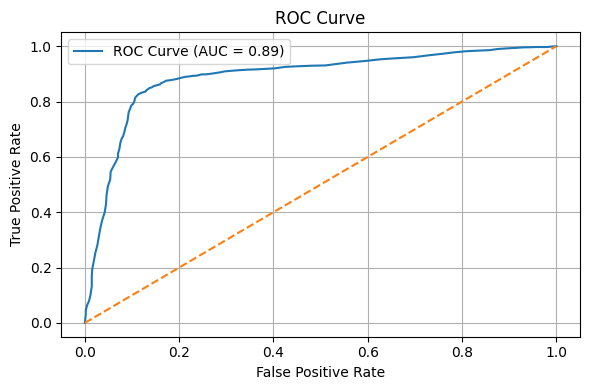

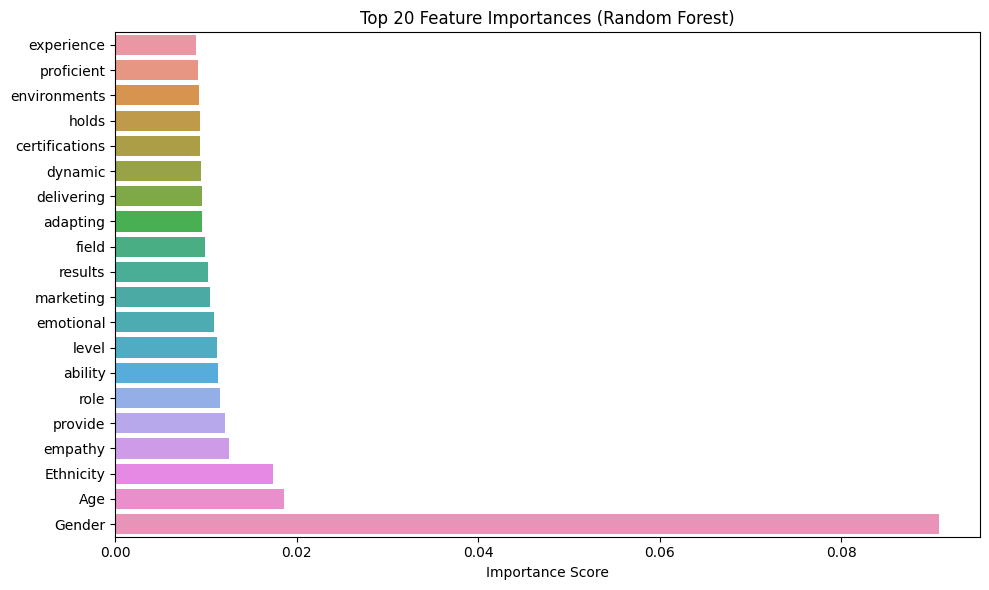

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def train_random_forest(X_train, y_train, random_state=42):
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("✅ Accuracy:", accuracy_score(y_test, y_pred))
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred))
    print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n✅ ROC AUC Score:", roc_auc_score(y_test, y_proba))

    return y_pred, y_proba

def plot_roc_curve(y_test, y_proba):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, vectorizer, structured_features, top_n=20):
    importances = model.feature_importances_
    tfidf_feature_names = vectorizer.get_feature_names_out()
    feature_names = list(tfidf_feature_names) + structured_features

    top_indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[top_indices], y=np.array(feature_names)[top_indices])
    plt.title(f"Top {top_n} Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

# Run Training and Evaluation
rf_model = train_random_forest(X_train, y_train)
y_pred_rf, y_proba_rf = evaluate_model(rf_model, X_test, y_test)

# Visualizations
plot_roc_curve(y_test, y_proba_rf)
plot_feature_importance(rf_model, tfidf_vectorizer, structured_features=['Age', 'Gender', 'Race', 'Ethnicity'])


In [19]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

def evaluate_fairness_with_fairlearn(y_true, y_pred, sensitive_features, sensitive_name="Gender"):
    print(f"\n--- 📊 Fairlearn Metrics by {sensitive_name} ---")
    
    metric_frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive_features
    )

    print(metric_frame.by_group)
    print("\n✅ Overall accuracy:", metric_frame.overall["accuracy"])
    print("📉 Disparity in selection rate:", metric_frame.difference()["selection_rate"])

    return metric_frame

# Run Evaluation
sensitive_gender = df_test["Gender"].values  
y_pred_rf = rf_model.predict(X_test)         

metric_frame_gender = evaluate_fairness_with_fairlearn(y_test, y_pred_rf, sensitive_gender, "Gender")



--- 📊 Fairlearn Metrics by Gender ---
                     accuracy selection_rate
sensitive_feature_0                         
0                    0.855521       0.323013
1                     0.85548       0.621726

✅ Overall accuracy: 0.8555
📉 Disparity in selection rate: 0.2987130632537869


In [20]:
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score
)

def manual_reweighing(df_train, X_train, y_train, sensitive_col, model):
    """
    Reweigh samples to remove bias with respect to a sensitive attribute.
    Returns a re-trained model and the sample weights.
    """
    df_tmp = df_train.copy()
    df_tmp['label'] = y_train

    # Observed joint probability P(G, Y)
    joint = (
        df_tmp.groupby([sensitive_col, 'label'])
        .size()
        .div(len(df_tmp))
        .rename('p_obs')
        .reset_index()
    )

    # Marginal distributions
    p_g = df_tmp[sensitive_col].value_counts(normalize=True)
    p_y = df_tmp['label'].value_counts(normalize=True)

    # Desired independent distribution P(G) * P(Y)
    joint['p_g'] = joint[sensitive_col].map(p_g)
    joint['p_y'] = joint['label'].map(p_y)
    joint['p_des'] = joint['p_g'] * joint['p_y']

    # Compute sample weights
    joint['w'] = joint['p_des'] / joint['p_obs']

    # Merge weights back into original df
    df_tmp = df_tmp.merge(
        joint[[sensitive_col, 'label', 'w']],
        on=[sensitive_col, 'label'],
        how='left'
    )

    # Train the model using these weights
    reweighted_model = clone(model)
    reweighted_model.fit(X_train, y_train, sample_weight=df_tmp['w'].values)

    return reweighted_model, df_tmp['w'].values


def print_model_performance(y_true, y_pred, title="Model Performance"):
    print(f"\n📊 {title}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall   :", recall_score(y_true, y_pred, zero_division=0))
    print("F1‑Score :", f1_score(y_true, y_pred, zero_division=0))


def evaluate_fairness_simple(df, group_col, y_true_col='y_true', y_pred_col='y_pred_rw'):
    """
    Print simple fairness metrics: Selection Rate, DIR, EOD.
    """
    sel_rate = df.groupby(group_col)[y_pred_col].mean()
    dir_ratio = sel_rate.min() / sel_rate.max()
    rec_by_grp = df.groupby(group_col).apply(
        lambda g: recall_score(g[y_true_col], g[y_pred_col], zero_division=0)
    )
    eo_diff = abs(rec_by_grp.max() - rec_by_grp.min())

    print(f"\n--- ⚖️ Fairness: {group_col.upper()} ---")
    print("Selection Rate:\n", sel_rate)
    print(f"Disparate Impact Ratio: {dir_ratio:.3f}")
    print(f"Equal Opportunity Difference: {eo_diff:.3f}")


# === Execution ===
sensitive_attr = 'Gender'  # Can be changed to 'Race' or 'Ethnicity'

# 1️⃣ Manual reweighing & model training
rf_model_rw, sample_w = manual_reweighing(
    df_train, X_train, y_train,
    sensitive_col=sensitive_attr,
    model=rf_model  # previously defined model
)

# 2️⃣ Make predictions on test set
y_pred_rw = rf_model_rw.predict(X_test)
df_test['y_pred_rw'] = y_pred_rw
df_test['y_true'] = y_test  # ground truth

# 3️⃣ Performance metrics
print_model_performance(y_test, y_pred_rw, title="PERFORMANCE AFTER MANUAL REWEIGHING")

# 4️⃣ Fairness evaluation for multiple sensitive features
print("\n⚖️  FAIRNESS AFTER MANUAL REWEIGHING")
for col in ['Gender', 'Race', 'Ethnicity']:
    evaluate_fairness_simple(df_test, group_col=col)



📊 PERFORMANCE AFTER MANUAL REWEIGHING
Accuracy : 0.837
Precision: 0.8401253918495298
Recall   : 0.8229273285568065
F1‑Score : 0.8314374353671149

⚖️  FAIRNESS AFTER MANUAL REWEIGHING

--- ⚖️ Fairness: GENDER ---
Selection Rate:
 Gender
0    0.311662
1    0.635306
Name: y_pred_rw, dtype: float64
Disparate Impact Ratio: 0.491
Equal Opportunity Difference: 0.181

--- ⚖️ Fairness: RACE ---
Selection Rate:
 Race
0    0.471125
1    0.483180
2    0.481105
Name: y_pred_rw, dtype: float64
Disparate Impact Ratio: 0.975
Equal Opportunity Difference: 0.019

--- ⚖️ Fairness: ETHNICITY ---
Selection Rate:
 Ethnicity
0     0.454545
1     0.514286
2     0.418367
3     0.483146
4     0.443299
5     0.453608
6     0.463415
7     0.449541
8     0.521277
9     0.437500
10    0.500000
11    0.500000
12    0.471910
13    0.505376
14    0.495050
15    0.512500
16    0.421053
17    0.500000
18    0.500000
19    0.477273
20    0.519231
Name: y_pred_rw, dtype: float64
Disparate Impact Ratio: 0.803
Equal Opport

In [21]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate

def apply_inprocessing_fairness(X_train, y_train, X_test, y_test, sensitive_train, sensitive_test, sensitive_name="Gender"):
    """
    Applies in-processing fairness mitigation using Exponentiated Gradient with Demographic Parity.
    Returns predictions and fairness metric frame.
    """
    # Convert sparse matrices to dense for fairlearn's compatibility
    X_train_dense = X_train.toarray()
    X_test_dense = X_test.toarray()

    # Fairness-aware training
    mitigator = ExponentiatedGradient(
        estimator=LogisticRegression(max_iter=1000),
        constraints=DemographicParity()
    )
    mitigator.fit(X_train_dense, y_train, sensitive_features=sensitive_train)

    # Prediction
    y_pred = mitigator.predict(X_test_dense)

    # Fairness metric evaluation
    metric_frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=sensitive_test
    )

    print(f"\n✅ Mitigated Fairness Metrics by {sensitive_name}:")
    print(metric_frame.by_group)
    print(f"\nOverall Accuracy: {metric_frame.overall['accuracy']:.3f}")
    print(f"Selection Rate Disparity: {metric_frame.difference()['selection_rate']:.3f}")

    return y_pred, metric_frame


# === Run In-processing Fairness Mitigation ===
y_pred_mitigated, metric_frame_mitigated = apply_inprocessing_fairness(
    X_train, y_train, X_test, y_test,
    sensitive_train=df_train["Gender"],
    sensitive_test=df_test["Gender"],
    sensitive_name="Gender"
)


c:\Users\lenovo\anaconda3\envs\tf115-env\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\Users\lenovo\anaconda3\envs\tf115-env\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
c:\Users\lenovo\anaconda3\envs\tf115-env\lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations 


✅ Mitigated Fairness Metrics by Gender:
        accuracy selection_rate
Gender                         
0       0.485036       0.480908
1        0.57129       0.531523

Overall Accuracy: 0.529
Selection Rate Disparity: 0.051


In [22]:
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

def apply_postprocessing_fairness(X_train, y_train, X_test, y_test,
                                   sensitive_train, sensitive_test,
                                   sensitive_name="Gender"):
    """
    Applies post-processing fairness mitigation using ThresholdOptimizer.
    Returns predictions and fairness metric frame.
    """
    # Step 1: Train logistic regression
    base_model = LogisticRegression(max_iter=1000)
    base_model.fit(X_train.toarray(), y_train)

    # Step 2: Apply post-processing with fairness constraints
    postprocessor = ThresholdOptimizer(
        estimator=base_model,
        constraints="demographic_parity",
        prefit=True
    )
    postprocessor.fit(
        X_train.toarray(),
        y_train,
        sensitive_features=sensitive_train
    )

    # Step 3: Predict with fairness-aware thresholds
    y_pred_post = postprocessor.predict(
        X_test.toarray(),
        sensitive_features=sensitive_test
    )

    # Step 4: Fairness metrics
    metric_frame = MetricFrame(
        metrics={"accuracy": accuracy_score, "selection_rate": selection_rate},
        y_true=y_test,
        y_pred=y_pred_post,
        sensitive_features=sensitive_test
    )

    print(f"\n✅ ThresholdOptimizer (Post-processing) Metrics by {sensitive_name}:")
    print(metric_frame.by_group)
    print("Overall Accuracy:", round(metric_frame.overall["accuracy"], 3))
    print("Selection Rate Disparity:", round(metric_frame.difference()["selection_rate"], 3))

    return y_pred_post, metric_frame

# === Run Post-processing Fairness Mitigation ===
y_pred_post, metric_frame_post = apply_postprocessing_fairness(
    X_train, y_train, X_test, y_test,
    sensitive_train=df_train["Gender"],
    sensitive_test=df_test["Gender"],
    sensitive_name="Gender"
)



✅ ThresholdOptimizer (Post-processing) Metrics by Gender:
        accuracy selection_rate
Gender                         
0       0.649123       0.003096
1       0.386033        0.00291
Overall Accuracy: 0.514
Selection Rate Disparity: 0.0


c:\Users\lenovo\anaconda3\envs\tf115-env\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:275: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  FutureWarning,


In [24]:
from fairlearn.metrics import demographic_parity_difference

# Assuming this is for the baseline model
spd = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_rf,
    sensitive_features=df_test["Gender"]
)
print("SPD (Baseline):", spd)

SPD (Baseline): 0.2987130632537869


In [25]:
spd_rw = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=df_test["Gender"]
)
print("SPD (Re-weighting):", spd_rw)


SPD (Re-weighting): 0.3236440219050507


In [26]:
spd_ip = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_mitigated,
    sensitive_features=df_test["Gender"]
)
print("SPD (In-processing):", spd_ip)


SPD (In-processing): 0.05061464066968363


In [27]:
spd_pp = demographic_parity_difference(
    y_true=y_test,
    y_pred=y_pred_post,
    sensitive_features=df_test["Gender"]
)
print("SPD (Post-processing):", spd_pp)


SPD (Post-processing): 0.00018617891794014052
